# ECG Classification - Complete Project in Colab
## Multi-Modal Deep Learning for ECG Analysis

**Your complete original project - no modifications**

This notebook contains ALL your code exactly as you wrote it:
- ✅ Your custom RNN models (GRU/LSTM with attention)
- ✅ Your custom CNN2D models (AlexNet-inspired with attention)
- ✅ Your custom ResNet and VGG implementations
- ✅ Your fusion models
- ✅ Your data loaders with caching
- ✅ Your training pipeline
- ✅ Your metrics and evaluation
- ✅ Everything from your project files

**5-class ECG Classification**: NORM, MI, STTC, CD, HYP  
**Dataset**: PTB-XL from PhysioNet


## 1. Setup & Installation


In [ ]:
# Check environment and GPU
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running on Google Colab")
except:
    IN_COLAB = False
    print("✗ Not running on Colab")

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ No GPU detected - training will be slow!")


✓ Running on Google Colab

PyTorch version: 2.9.0+cpu
CUDA available: False
⚠ No GPU detected - training will be slow!


In [ ]:
# Install dependencies
!pip install -q torch torchvision torchaudio
!pip install -q numpy pandas matplotlib seaborn scikit-learn tqdm
!pip install -q wfdb pyts  # For PTB-XL and time series conversion

print("✓ Dependencies installed successfully")


In [ ]:
# Setup storage for collab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    SAVE_DIR = '/content/drive/MyDrive/ECG_Checkpoints/'
else:
    SAVE_DIR = 'checkpoints/'

import os
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs('results', exist_ok=True)

# Create data directories
data_dirs = [
    'data/signals/train', 'data/signals/validation', 'data/signals/test',
    'data/images/train/gaf', 'data/images/train/mtf',
    'data/images/validation/gaf', 'data/images/validation/mtf',
    'data/images/test/gaf', 'data/images/test/mtf',
    'data/labels'
]
for d in data_dirs:
    os.makedirs(d, exist_ok=True)

print(f"✓ Directories created")
print(f"  Checkpoints: {SAVE_DIR}")
print(f"  Results: results/")
print(f"  Data: data/")


## 2. Configuration


**From: `config.py`** - Your original configuration


In [ ]:
import torch
import os

# Configurations, Adjust Properly
class Config:
    # Data paths
    TRAIN_SIGNAL_PATH = 'data/signals/train/'
    TRAIN_IMAGE_PATH = 'data/images/train/'
    TRAIN_LABEL_PATH = 'data/labels/y_train.npy'
    VAL_SIGNAL_PATH = 'data/signals/validation/'
    VAL_IMAGE_PATH = 'data/images/validation/'
    VAL_LABEL_PATH = 'data/labels/y_val.npy'
    TEST_SIGNAL_PATH = 'data/signals/test/'
    TEST_IMAGE_PATH = 'data/images/test/'
    TEST_LABEL_PATH = 'data/labels/y_test.npy'

    METRICS_SAVE_PATH = 'saved_metrics'
    if not os.path.exists(METRICS_SAVE_PATH):
        os.makedirs(METRICS_SAVE_PATH)
    TRAIN_HISTORY_SAVE_PATH = 'training_history'
    if not os.path.exists(TRAIN_HISTORY_SAVE_PATH):
        os.makedirs(TRAIN_HISTORY_SAVE_PATH)
    EVAL_METRICS_SAVE_PATH = 'evaluation_metrics'
    if not os.path.exists(EVAL_METRICS_SAVE_PATH):
        os.makedirs(EVAL_METRICS_SAVE_PATH)

    # Data loading parameters
    SAVED_BATCH_SIZE = 32

    # Model parameters
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.3

    # Optimization
    WEIGHT_DECAY = 1e-4  # L2 regularization
    PATIENCE = 5  # Early stopping patience

    # Training parameters
    BATCH_SIZE = 64 # Should be in multiple of SAVE_BATCH_SIZE
    NUM_EPOCHS = 10  # Small number for testing
    LEARNING_RATE = 0.001
    SAVE_BEST = True

    # Other
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SAVE_DIR = '/content/checkpoints/'
    NUM_WORKERS = 4

    # Classes
    CLASS_NAMES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    NUM_CLASSES = 5


# Update save directory
Config.SAVE_DIR = SAVE_DIR
config = Config()
print(f"✓ Configuration loaded")
print(f"  Device: {config.DEVICE}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Epochs: {config.NUM_EPOCHS}")


✓ Configuration loaded
  Device: cuda
  Batch size: 64
  Epochs: 10


<!-- Downloading the data and extracting in /data -->
## From: Downloading and extracting PTB-CL dataset into /data

In [ ]:
import os
import urllib.request
import zipfile
import tarfile
from tqdm.auto import tqdm

# Create data directory
os.makedirs('/content/data', exist_ok=True)
os.chdir('/content/data')

# ============================================================================
# Download and Setup PTB-XL Dataset in Google Colab
# ============================================================================

print("=" * 60)
print("DOWNLOADING PTB-XL DATASET")
print("=" * 60)

# ============================================================================
# Method 1: Download from PhysioNet (Official Source)
# ============================================================================

def download_with_progress(url, filename):
    """Download file with progress bar"""
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
        urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)

# Download PTB-XL dataset (about 8.5 GB)
print("\n1. Downloading PTB-XL dataset from PhysioNet...")
print("   This may take 10-20 minutes depending on connection speed...")

PTB_XL_URL = "https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip"
PTB_XL_ZIP = "ptb-xl-dataset.zip"

download_with_progress(PTB_XL_URL, PTB_XL_ZIP)
print("✓ Download complete!")

# ============================================================================
# Extract the dataset
# ============================================================================

print("\n2. Extracting dataset...")
with zipfile.ZipFile(PTB_XL_ZIP, 'r') as zip_ref:
    # Get list of all files
    file_list = zip_ref.namelist()

    # Extract with progress bar
    for file in tqdm(file_list, desc="Extracting"):
        zip_ref.extract(file, '/content/data/')

print("✓ Extraction complete!")

# Move files from nested directory to /content/data/
print("\n3. Organizing files...")
import shutil

extracted_dir = '/content/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
if os.path.exists(extracted_dir):
    # Move all contents to /content/data/
    for item in os.listdir(extracted_dir):
        src = os.path.join(extracted_dir, item)
        dst = os.path.join('/content/data/', item)
        if os.path.exists(dst):
            if os.path.isdir(dst):
                shutil.rmtree(dst)
            else:
                os.remove(dst)
        shutil.move(src, dst)

    # Remove empty extracted directory
    shutil.rmtree(extracted_dir)
    print("✓ Files organized!")

# Clean up zip file
os.remove(PTB_XL_ZIP)
print("✓ Cleaned up temporary files")


In [ ]:
# !pip install rarfile

from google.colab import drive
import shutil
import rarfile

# Mount Google Drive
drive.mount('/content/drive')

# Option 1: If you have the dataset in your Drive
# print("Copying Signals and Labels from Google Drive...")
SIGNALS_PATH = '/content/drive/MyDrive/signals.rar'
LABELS_PATH = '/content/drive/MyDrive/labels.rar'

rar_path_signals = '/content/data/signals.rar'
rar_path_labels = '/content/data/labels.rar'
extract_to = '/content/data/'

if os.path.exists(SIGNALS_PATH):
    shutil.copy(SIGNALS_PATH, '/content/data/signals.rar')
if os.path.exists(LABELS_PATH):
    shutil.copy(LABELS_PATH, '/content/data/labels.rar')

# Extract
print("Extracting Signals and Labels from into /data...")
with rarfile.RarFile(rar_path_signals) as rf:
    rf.extractall(path=extract_to)
with rarfile.RarFile(rar_path_labels) as rf:
    rf.extractall(path=extract_to)

print("✓ Dataset copied and extracted from Google Drive!")

In [ ]:
# ============================================================================
# Verify the dataset structure
# ============================================================================

print("\n4. Verifying dataset structure...")
print("=" * 80)

required_files = [
    'ptbxl_database.csv',
    'scp_statements.csv',
    'records100',  # 100Hz recordings
    'records500',  # 500Hz recordings
]

all_present = True
for item in required_files:
    path = os.path.join('/content/data/', item)
    if os.path.exists(path):
        if os.path.isdir(path):
            num_files = len([f for f in os.listdir(path) if not f.startswith('.')])
            print(f"✓ {item}/ - {num_files} files")
        else:
            size_mb = os.path.getsize(path) / (1024 * 1024)
            print(f"✓ {item} - {size_mb:.2f} MB")
    else:
        print(f"✗ {item} - NOT FOUND")
        all_present = False

if all_present:
    print("\n✓ Dataset verification successful!")
    print("=" * 80)
else:
    print("\n⚠ Some files are missing!")
    print("=" * 80)

In [ ]:
# ============================================================================
# Display dataset info
# ============================================================================

print("\nDATASET INFORMATION:")
import pandas as pd

df = pd.read_csv('/content/data/ptbxl_database.csv')
print(f"Total ECG records: {len(df)}")
print(f"Sampling rates: 100Hz and 500Hz")
print(f"Duration: 10 seconds")
print(f"Leads: 12-lead ECG")

print("\nClass distribution (diagnostic superclass):")
df['scp_codes'] = df['scp_codes'].apply(lambda x: eval(x))

classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
for cls in classes:
    count = sum(cls in codes for codes in df['scp_codes'])
    percentage = (count / len(df)) * 100
    print(f"  {cls}: {count} ({percentage:.1f}%)")

print("\n" + "=" * 80)
print("✓ PTB-XL DATASET READY!")
print("=" * 80)
print(f"\nDataset location: /content/data/")
print(f"Database file: /content/data/ptbxl_database.csv")
print(f"100Hz signals: /content/data/records100/")
print(f"500Hz signals: /content/data/records500/")
print("\nYou can now proceed to preprocess the data!")

## 3. Data Loading - Precision Cache


**From: `precission_cache.py`** - Your memory-efficient caching system


In [ ]:
from collections import OrderedDict

class PrecisionCache:
    def __init__(self, capacity: int):
        """
        capacity: Maximum number of batches to store in RAM.
        """
        self.cache = OrderedDict()
        self.capacity = capacity

    def get_batch(self, key):
        """Returns the batch if it exists, otherwise returns None."""
        if key not in self.cache:
            return None

        # Move to end (mark as most recently used)
        self.cache.move_to_end(key)
        return self.cache[key]

    def add_batch(self, key, batch_data):
        """Adds a batch. Evicts the oldest if capacity is reached."""
        if key in self.cache:
            self.cache.move_to_end(key)
        self.cache[key] = batch_data

        if len(self.cache) > self.capacity:
            # last=False pops the first item (the Least Recently Used)
            self.cache.popitem(last=False)

print("✓ PrecisionCache loaded")


## 4. Data Loading - Signal DataLoader


**From: `signal_dataloader.py`** - Your signal data loader


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
# from .precission_cache import PrecisionCache

class ECGSignalDataset(Dataset):
    """PyTorch Dataset for PTB-XL ECG data"""

    def __init__(self, signals_path, labels_path, saved_batch_size, transform=None):
        """
        Args:
            signals: Path to directory containing image batches (e.g., 'data/signals/train/')
            labels_path: Path to labels .npy file
            saved_batch_size: Number of samples per saved batch file (default: 32)
            transform: Optional transforms to apply
        """
        # data can be either raw signals or precomputed images depending on the model
        self.image_path = signals_path
        self.labels = np.load(labels_path)
        self.saved_batch_size = saved_batch_size
        self.transform = transform
        self.cache = PrecisionCache(capacity=50)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Calculate which batch file and position within that batch
        batch_no = idx // self.saved_batch_size
        sample_idx = idx % self.saved_batch_size

        # Try to get from cache
        batch = self.cache.get_batch(batch_no)

        # Load from disk if not in cache
        if batch is None:
            batch_file = os.path.join(self.image_path, f"batch_{batch_no}.npy")

            if not os.path.exists(batch_file):
                raise FileNotFoundError(f"Batch file not found: {batch_file}")

            batch = np.load(batch_file)
            self.cache.add_batch(batch_no, batch)

        # Handle last batch edge case
        if sample_idx >= len(batch):
            raise IndexError(
                f"Sample index {sample_idx} out of bounds for batch {batch_no} "
                f"with {len(batch)} samples"
            )

        # Get image and label
        signal = batch[sample_idx].astype(np.float32)
        label = self.labels[idx].astype(np.float32)

        # Convert to tensors
        signal = torch.from_numpy(signal).float()
        label = torch.from_numpy(label).float()

        # Apply transforms if any
        if self.transform:
            signal = self.transform(signal)

        return signal, label

def create_signal_dataloader(
    image_path,
    labels_path,
    saved_batch_size=32,
    batch_size=16,  # DataLoader batch size (can be different from saved_batch_size)
    shuffle=True,
    num_workers=4
):
    """
    Create dataloader for signal data

    Args:
        signals_path: Path to Signals directory
        labels_path: Path to labels file
        saved_batch_size: Size of saved batch files (default: 32)
        batch_size: DataLoader batch size (default: 16)
        shuffle: Whether to shuffle data
        num_workers: Number of worker processes
    """
    dataset = ECGSignalDataset(
        signals_path=image_path,
        labels_path=labels_path,
        saved_batch_size=saved_batch_size,
        transform=None
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory= torch.cuda.is_available()
    )

    return loader



print("✓ SignalDataLoader loaded")


✓ SignalDataLoader loaded


## 5. Data Loading - Image DataLoader


**From: `image_dataloader.py`** - Your image data loader (GAF/MTF)


In [ ]:
"""
DataLoader for ECG Images (GAF/MTF/MT or multiple)
"""

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
# from .precission_cache import PrecisionCache


class ECGImageDataset(Dataset):
    """
    Dataset for loading batched ECG images
    """
    def __init__(self, image_path, labels_path, saved_batch_size=32, transform_type='gaf', transform=None):
        """
        Args:
            image_path: Path to directory containing image batches (e.g., 'data/images/train/')
            labels_path: Path to labels .npy file
            saved_batch_size: Number of samples per saved batch file (default: 32)
            transform_type: 'gaf', 'mtf', or ['gaf', 'mtf'] to load both
            transform: Optional transforms to apply
        """
        self.labels = np.load(labels_path)
        self.saved_batch_size = saved_batch_size
        self.transform = transform
        self.cache = PrecisionCache(capacity=50)

        # Handle both string and list input for transform_type
        if isinstance(transform_type, str):
            self.transform_type = [transform_type]
        else:
            self.transform_type = transform_type

        # Build image paths for each transform type
        self.image_paths = []
        for t_type in self.transform_type:
            img_path = os.path.join(image_path, t_type)
            if not os.path.exists(img_path):
                raise ValueError(f"Image directory not found: {img_path}")
            self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Calculate which batch file and position within that batch
        batch_no = idx // self.saved_batch_size
        sample_idx = idx % self.saved_batch_size

        # Get image(s) from all transform types
        images = []
        for i, image_path in enumerate(self.image_paths):
            # Try to get from cache (use unique key combining path index and batch number)
            cache_key = (i, batch_no)
            batch = self.cache.get_batch(cache_key)

            # Load from disk if not in cache
            if batch is None:
                batch_file = os.path.join(image_path, f"batch_{batch_no}.npy")

                if not os.path.exists(batch_file):
                    raise FileNotFoundError(f"Batch file not found: {batch_file}")

                batch = np.load(batch_file)
                self.cache.add_batch(cache_key, batch)

            # Handle last batch edge case
            if sample_idx >= len(batch):
                raise IndexError(
                    f"Sample index {sample_idx} out of bounds for batch {batch_no} "
                    f"with {len(batch)} samples"
                )

            # Get image
            image = batch[sample_idx].astype(np.float32)

            # Normalize image to [0, 1] if needed
            if image.max() > 1.0:
                image = image / 255.0

            images.append(image)

        # Get label
        label = self.labels[idx].astype(np.float32)

        # Convert to tensors and apply transforms
        if len(images) > 1:
            # Return separate tensors for each image type
            image_tensors = []
            for image in images:
                img_tensor = torch.from_numpy(image).float()
                if self.transform:
                    img_tensor = self.transform(img_tensor)
                image_tensors.append(img_tensor)
            label = torch.from_numpy(label).float()
            return tuple(image_tensors), label
        else:
            # Return single image tensor
            image = torch.from_numpy(images[0]).float()
            label = torch.from_numpy(label).float()
            if self.transform:
                image = self.transform(image)
            return image, label


def create_image_dataloader(
    image_path,
    labels_path,
    saved_batch_size=32,
    transform_type='gaf',
    batch_size=16,  # DataLoader batch size (can be different from saved_batch_size)
    shuffle=True,
    num_workers=4
):
    """
    Create dataloader for image data

    Args:
        image_path: Path to image directory
        labels_path: Path to labels file
        saved_batch_size: Size of saved batch files (default: 32)
        transform_type: 'gaf', 'mtf', or ['gaf', 'mtf'] to load both types
        batch_size: DataLoader batch size (default: 16)
        shuffle: Whether to shuffle data
        num_workers: Number of worker processes
    """
    dataset = ECGImageDataset(
        image_path=image_path,
        labels_path=labels_path,
        saved_batch_size=saved_batch_size,
        transform_type=transform_type,
        transform=None
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory= torch.cuda.is_available()
    )

    return loader



print("✓ ImageDataLoader loaded")


## 6. Data Loading - Fusion DataLoader


**From: `fusion_dataloader.py`** - Your fusion data loader


In [ ]:
"""
DataLoader for ECG Images (GAF/MTF)
"""

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
# from .precission_cache import PrecisionCache


class ECGFusionDataset(Dataset):
    """
    Dataset for loading batched ECG Signalss + images
    """
    def __init__(self, signal_path, image_path, labels_path, saved_batch_size=32, transform_type='gaf', transform=None):
        """
        Args:
            image_path: Path to directory containing image batches (e.g., 'data/images/train/')
            signal_path: Path to directory containing signals batches (e.g., 'data/signals/train/')
            labels_path: Path to labels .npy file
            saved_batch_size: Number of samples per saved batch file (default: 32)
            transform_type: 'gaf' or 'mtf'
            transform: Optional transforms to apply
        """
        self.image_path = os.path.join(image_path, transform_type)
        self.signal_path = os.path.join(signal_path)
        self.labels = np.load(labels_path)
        self.saved_batch_size = saved_batch_size
        self.transform_type = transform_type
        self.transform = transform
        self.cache = PrecisionCache(capacity=50)

        # Verify directories exists
        if not os.path.exists(self.image_path):
            raise ValueError(f"Image directory not found: {self.image_path}")
        if not os.path.exists(self.signal_path):
            raise ValueError(f"Signal directory not found: {self.signal_path}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Calculate which batch file and position within that batch
        batch_no = idx // self.saved_batch_size
        sample_idx = idx % self.saved_batch_size

        # Try to get from cache
        signal_batch = self.cache.get_batch(f"signal_b_{batch_no}")
        image_batch = self.cache.get_batch(f"image_b_{batch_no}")

        # Load from disk if not in cache
        if signal_batch is None:
            batch_file = os.path.join(self.signal_path, f"batch_{batch_no}.npy")

            if not os.path.exists(batch_file):
                raise FileNotFoundError(f"Signals Batch file not found: {batch_file}")

            signal_batch = np.load(batch_file)
            self.cache.add_batch(f"signal_b_{batch_no}", signal_batch)

        if image_batch is None:
            batch_file = os.path.join(self.image_path, f"batch_{batch_no}.npy")

            if not os.path.exists(batch_file):
                raise FileNotFoundError(f"Image Batch file not found: {batch_file}")

            image_batch = np.load(batch_file)
            self.cache.add_batch(f"image_b_{batch_no}", image_batch)

        # Handle last batch edge case
        if sample_idx >= len(signal_batch) or sample_idx >= len(image_batch):
            raise IndexError(
                f"Sample index {sample_idx} out of bounds for batch {batch_no} "
                f"with {len(signal_batch)} samples"
            )
        # Get image and label
        signal = signal_batch[sample_idx].astype(np.float32)
        image = image_batch[sample_idx].astype(np.float32)
        label = self.labels[idx].astype(np.float32)

        # Normalize image to [0, 1] if needed
        if image.max() > 1.0:
            image = image / 255.0

        # Convert to tensors
        signal = torch.from_numpy(signal).float()
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        # Apply transforms if any
        if self.transform:
            signal = self.transform(signal)
            image = self.transform(image)

        return (signal, image), label


def create_fusion_dataloader(
    signal_path,
    image_path,
    labels_path,
    saved_batch_size=32,
    transform_type='gaf',
    batch_size=32,  # DataLoader batch size (can be different from saved_batch_size)
    shuffle=True,
    num_workers=4
):
    """
    Create dataloader for image data

    Args:
        image_path: Path to image directory
        labels_path: Path to labels file
        saved_batch_size: Size of saved batch files (default: 32)
        transform_type: 'gaf' or 'mtf'
        batch_size: DataLoader batch size (default: 16)
        shuffle: Whether to shuffle data
        num_workers: Number of worker processes
    """
    dataset = ECGFusionDataset(
        image_path=image_path,
        signal_path= signal_path,
        labels_path=labels_path,
        saved_batch_size=saved_batch_size,
        transform_type=transform_type,
        transform=None
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory= torch.cuda.is_available()
    )

    return loader



print("✓ FusionDataLoader loaded")


## 7. Models - RNN Block


**From: `rnn_block.py`** - Your RNN building blocks (GRU/LSTM)


In [ ]:
"""
RNN Models for ECG Classification
- GRU
- BiGRU
- LSTM
- BiLSTM
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class RNN_BLOCK(nn.Module):
    """Base class for GRU/LSTM models"""
    def __init__(
        self,
        input_size=3,       # 3 leads
        hidden_size=128,
        num_layers=2,
        dropout=0.3,
        bidirectional=False,
        rnn_type='gru'      # 'gru' or 'lstm'
    ):
        super(RNN_BLOCK, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn_type = rnn_type
        self.d = 2 if self.bidirectional else 1

        if self.rnn_type == 'gru':
            self.rnn = nn.GRU(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                dropout=dropout if self.num_layers > 1 else 0,
                bidirectional=self.bidirectional,
                batch_first=True
            )
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                dropout=dropout if self.num_layers > 1 else 0,
                bidirectional=self.bidirectional,
                batch_first=True,
            )
        else:
            raise ValueError(f"Unidentified rnn type: {rnn_type}")

    def forward(self, x):
        """
        Args:
            x: (batch, num_leads, signal_length) = (batch, 3, 1000)
        Returns:
            out: (batch, seq_length, hidden_size * d)
            hidden: (batch, hidden_size * d)
        """
        device = x.device

        # Transpose to (batch, seq_len, features)
        x_transposed = x.transpose(1, 2)  # (batch, 1000, 3)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers * self.d, x.size(0), self.hidden_size).to(device)

        if self.rnn_type == 'gru':
            out, hn = self.rnn(x_transposed, h0)
        elif self.rnn_type == 'lstm':
            c0 = torch.zeros(self.num_layers * self.d, x.size(0), self.hidden_size).to(device)
            out, (hn, cn) = self.rnn(x_transposed, (h0, c0))

        # Extract hidden state
        if not self.bidirectional:
            hidden = hn[-1]  # (batch, hidden_size)
        else:
            # Concatenate forward and backward hidden states
            hidden = torch.cat([hn[-2], hn[-1]], dim=1)  # (batch, hidden_size*2)

        return out, hidden


class FullyConnected(nn.Module):
    """Fully connected layers for classification"""
    def __init__(self, input_size, output_size, dropout=0.3):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(input_size, input_size * 2)
        self.bn1 = nn.BatchNorm1d(input_size * 2)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(input_size * 2, input_size)
        self.bn2 = nn.BatchNorm1d(input_size)
        self.dropout2 = nn.Dropout(dropout)

        self.output = nn.Linear(input_size, output_size)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        """
        Args:
            x: (batch, input_size)
        Returns:
            logits: (batch, output_size)
        """
        device = x.device

        out = self.fc1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.dropout2(out)

        logits = self.output(out)
        return logits

print("✓ RNN_BLOCK and FullyConnected loaded")


## 8. Models - RNN Attention Mechanisms


**From: `rnn_attention.py`** - Your attention mechanisms for RNN


In [ ]:
"""
Attention mechanisms for ECG classification
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


def scaled_dot_product_attention(Q, K, V, scale):
    """
    Scaled dot-product attention mechanism

    Args:
        Q: Query (batch, seq_len, hidden_size)
        K: Key (batch, seq_len, hidden_size)
        V: Value (batch, seq_len, hidden_size)
        scale: Scaling factor (usually sqrt(hidden_size))

    Returns:
        output: (batch, seq_len, hidden_size)
        weights: (batch, seq_len, seq_len)
    """
    scores = torch.bmm(Q, K.transpose(1, 2)) / scale  # (batch, seq_len, seq_len)
    weights = F.softmax(scores, dim=-1)
    output = torch.bmm(weights, V)  # (batch, seq_len, hidden_size)
    return output, weights


class AdditiveAttention(nn.Module):
    """
    Additive attention (Bahdanau attention)
    Computes attention weights over sequence and returns weighted sum
    """
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, hidden_size)
        Returns:
            context: (batch, hidden_size)
            attention_weights: (batch, seq_len)
        """
        # Compute attention scores
        attention_scores = self.attention(x)  # (batch, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch, seq_len)

        # Compute attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch, seq_len)

        # Compute context vector (weighted sum)
        context = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch, 1, seq_len)
            x  # (batch, seq_len, hidden_size)
        )  # (batch, 1, hidden_size)
        context = context.squeeze(1)  # (batch, hidden_size)

        return context, attention_weights


class SelfAttention(nn.Module):
    """
    Self-attention mechanism
    """
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.scale = hidden_size ** 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, hidden_size)
        Returns:
            attention: (batch, seq_len, hidden_size)
            weights: (batch, seq_len, seq_len)
        """
        device = x.device
        self.device = device

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention, weights = scaled_dot_product_attention(Q, K, V, self.scale)
        return attention, weights


class CrossAttention:
    """
    Note: This is private and experimental.
    Neither allowed to embed into training, nor allowed to replicate.
    Copyright protected.
    Author: Sujit Patel.
    https://github.com/sujitpatel2739/fusion_ecg
    """
    def __init__(self, hidden_size):
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.scale = hidden_size ** 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x, context):
        """
        Args:
            x: (batch, seq_len_x, hidden_size) - query source
            context: (batch, seq_len_c, hidden_size) - key/value source
        """
        device = x.device
        self.device = device

        Q = self.query(x)
        K = self.key(context)
        V = self.value(context)

        attention, weights = scaled_dot_product_attention(Q, K, V, self.scale)
        return attention, weights

print("✓ Attention mechanisms loaded (Additive, Self)")


## 9. Models - Complete RNN Model


**From: `rnn.py`** - Your complete RNN model with convenience functions


In [ ]:
"""
Complete ECG Classification Model
Combines RNN block + optional Attention + FC layers
"""

import torch
import torch.nn as nn
# from .rnn_block import RNN_BLOCK, FullyConnected
# from .rnn_attention import AdditiveAttention, SelfAttention


class RNNModel(nn.Module):
    """
    Configurable ECG classification model
    Supports: GRU, BiGRU, LSTM, BiLSTM with optional Attention
    """
    def __init__(
        self,
        input_size=3,
        hidden_size=128,
        num_layers=2,
        num_classes=5,
        dropout=0.3,
        bidirectional=False,
        attention=None,  # None, 'additive', or 'self'
        rnn_type='gru'   # 'gru' or 'lstm'
    ):
        super(RNNModel, self).__init__()

        self.bidirectional = bidirectional
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.d = 2 if self.bidirectional else 1

        self.rnn_block = RNN_BLOCK(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            rnn_type=rnn_type
        )

        # Attention layer
        if attention == 'additive':
            self.attention = AdditiveAttention(hidden_size=hidden_size * self.d)
        elif attention == 'self':
            self.attention = SelfAttention(hidden_size=hidden_size * self.d)
        else:
            self.attention = None

        # Fully connected layers
        self.fc = FullyConnected(
            input_size=hidden_size * self.d,
            output_size=num_classes,
            dropout=dropout
        )

    def forward(self, x):
        """
        Args:
            x: (batch, num_leads, signal_length) = (batch, 3, 1000)
        Returns:
            logits: (batch, num_classes)
            attention_weights: (batch, seq_len) if attention, else None
        """
        device = x.device
        # RNN forward pass
        rnn_out, hidden = self.rnn_block(x)
        # rnn_out: (batch, seq_len, hidden_size*d)
        # hidden: (batch, hidden_size*d)


        # Apply attention if specified
        if self.attention_type == 'additive':
            context, attention_weights = self.attention(rnn_out)
            # context: (batch, hidden_size*d)
            fc_input = context

        elif self.attention_type == 'self':
            attention, attention_weights = self.attention(rnn_out)
            # attention: (batch, seq_len, hidden_size*d)
            # Use mean pooling over sequence
            fc_input = attention.mean(dim=1)  # (batch, hidden_size*d)

        else:
            # No attention - use hidden state from RNN
            attention_weights = None
            fc_input = hidden

        # Fully connected layers
        logits = self.fc(fc_input)

        if attention_weights is not None:
            return (logits, attention_weights)
        else:
            return logits


# ============= Convenience Functions =================================================

def create_gru(hidden_size=128, num_layers=2, dropout=0.3):
    """Create unidirectional GRU model"""
    return RNNModel(
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        bidirectional=False,
        attention=None,
        rnn_type='gru'
    )


def create_bigru(hidden_size=128, num_layers=2, dropout=0.3):
    """Create bidirectional GRU model"""
    return RNNModel(
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        bidirectional=True,
        attention=None,
        rnn_type='gru'
    )


def create_lstm(hidden_size=128, num_layers=2, dropout=0.3):
    """Create unidirectional LSTM model"""
    return RNNModel(
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        bidirectional=False,
        attention=None,
        rnn_type='lstm'
    )


def create_bilstm(hidden_size=128, num_layers=2, dropout=0.3):
    """Create bidirectional LSTM model"""
    return RNNModel(
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        bidirectional=True,
        attention=None,
        rnn_type='lstm'
    )


def create_bigru_attention(hidden_size=128, num_layers=2, dropout=0.3, attention_type='additive'):
    """Create bidirectional GRU with attention"""
    return RNNModel(
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        bidirectional=True,
        attention=attention_type,  # 'additive' or 'self'
        rnn_type='gru'
    )

print("✓ RNN Model loaded")
print("  Available: create_gru, create_bigru, create_lstm, create_bilstm, create_bigru_attention")


## 10. Models - CNN Attention Mechanisms


**From: `cnn_attention.py`** - Your CNN attention (Channel, Spatial, CBAM, Self)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    """
    Channel attention module (from CBAM paper)
    Focuses on 'WHAT' is meaningful
    """
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction_ratio, num_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        """
        Args:
            x: (batch, channels, height, width)
        Returns:
            out: (batch, channels, height, width)
        """
        device = x.device
        self.device = device

        batch, channels, _, _ = x.size()

        # Average pooling
        avg_out = self.avg_pool(x).view(batch, channels)
        avg_out = self.fc(avg_out)

        # Max pooling
        max_out = self.max_pool(x).view(batch, channels)
        max_out = self.fc(max_out)

        # Combine and apply sigmoid
        attention = self.sigmoid(avg_out + max_out)
        attention = attention.view(batch, channels, 1, 1)

        return x * attention.expand_as(x)

class SpatialAttention(nn.Module):
    """
    Spatial attention module (from CBAM paper)
    Focuses on 'WHERE' is meaningful
    """
    def __init__(self, in_channels, kernel_size=5):
        super(SpatialAttention, self).__init__()

        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'
    def forward(self, x):
        """
        Args:
            x: (batch, channels, height, width)
        Returns:
            out: (batch, channels, height, width)
        """
        device = x.device
        self.device = device

        # Channel-wise pooling
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        combined = torch.cat([avg_out, max_out], dim=1)

        attention = self.conv(combined)
        attention = self.sigmoid(attention)

        return x * attention


class SelfAttentionConv(nn.Module):
    """
    Self-Attention using 1x1 convolutions (Non-Local block)
    Works on 2D feature maps from CNNs
    """
    def __init__(self, in_channels, reduction_ratio=8):
        super(SelfAttentionConv, self).__init__()

        # Reduce channels for spatial learning
        self.inter_channels = in_channels // reduction_ratio

        # Q, K, V using 1x1 convolutions
        self.query_conv = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)

        # Output projection, exapnding back the reduced channels
        self.out_conv = nn.Conv2d(self.inter_channels, in_channels, kernel_size=1)

        # Learnable scaling parameter (optional)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        """
        Args:
            x: (batch, channels, height, width)
        Returns:
            out: (batch, channels, height, width)
        """
        device = x.device
        self.device = device

        batch, channels, height, width = x.size()

        Q = self.query_conv(x)   # (batch, inter_channels, H, W)
        K = self.key_conv(x)     # (batch, inter_channels, H, W)
        V = self.value_conv(x)   # (batch, inter_channels, H, W)

        # Reshape for matrix multiplication: (batch, inter_channels, H*W)
        Q = Q.view(batch, self.inter_channels, -1)
        K = K.view(batch, self.inter_channels, -1)
        V = V.view(batch, self.inter_channels, -1)

        # Transpose K for dot product
        K = K.permute(0, 2, 1)  # (batch, H*W, inter_channels)

        # Attention scores
        attention = torch.bmm(K, Q)  # (batch, H*W, H*W)
        attention = F.softmax(attention, dim=-1)

        # Apply attention to values
        attention = attention.permute(0, 2, 1) # (batch, H*W, H*W)
        out = torch.bmm(V, attention)  # (batch, inter_channels, H*W)

        # Reshape back to spatial dimensions
        out = out.view(batch, self.inter_channels, height, width)

        # Project back to original channels
        out = self.out_conv(out)  # (batch, channels, H, W)

        # Residual connection with learnable weight; optionally sacling by gamma factor
        out = self.gamma * out + x

        return out


class CrossAttention(nn.Module):
    """
    Note: This is private and experimental.
    Neither allowed to embed into training, nor allowed to replicate.
    Copyright protected.
    Author: Sujit Patel.
    https://github.com/sujitpatel2739/fusion_ecg

    Cross-Attention between GAF and MTF images
    GAF provides Query, MTF provides Key and Value

    """
    def __init__(self, in_channels, reduction_ratio=8):
        super(CrossAttention, self).__init__()

        self.inter_channels = in_channels // reduction_ratio

        # Q from GAF
        self.query_conv = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)

        # K, V from MTF
        self.key_conv = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)

        self.out_conv = nn.Conv2d(self.inter_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, gaf_features, mtf_features):
        """
        Args:
            gaf_features: (batch, channels, H, W) - Features from GAF CNN
            mtf_features: (batch, channels, H, W) - Features from MTF CNN
        Returns:
            out: (batch, channels, H, W) - Attended features
        """
        device = gaf_features.device
        self.device = device

        batch, channels, height, width = gaf_features.size()

        # Q from GAF, K & V from MTF
        Q = self.query_conv(gaf_features)   # (batch, inter_channels, H, W)
        K = self.key_conv(mtf_features)     # (batch, inter_channels, H, W)
        V = self.value_conv(mtf_features)   # (batch, inter_channels, H, W)

        # Reshape
        Q = Q.view(batch, self.inter_channels, -1)
        K = K.view(batch, self.inter_channels, -1)
        V = V.view(batch, self.inter_channels, -1)

        K = K.permute(0, 2, 1)  # (batch, H*W, inter_channels)

        # Attention
        attention = torch.bmm(K, Q)  # (batch, H*W, H*W)
        attention = F.softmax(attention, dim=-1)

        # Apply to values
        out = torch.bmm(V, attention.permute(0, 2, 1))
        out = out.view(batch, self.inter_channels, height, width)
        out = self.out_conv(out)

        # Residual with GAF features
        out = self.gamma * out + gaf_features

        return out

print("✓ CNN Attention mechanisms loaded")
print("  Available: ChannelAttention, SpatialAttention, SelfAttentionConv")


## 11. Models - CNN2D (AlexNet-inspired)


**From: `cnn2d_alexnet.py`** - Your custom AlexNet with attention variants


In [ ]:
"""
2D CNN Models for ECG Image Classification
- CNN2D (AlexNet-inspired)
- CNN2D with various attention mechanisms
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
# from .cnn_attention import ChannelAttention, SpatialAttention, SelfAttentionConv


class CNN2DClassifier(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(CNN2DClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_channels, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_channels),
        )
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'
    def forward(self, x):
        device = x.device
        self.device = device

        return self.classifier(x)


# ============= CNN2D (AlexNet-inspired) ==============================================
class CNN2D(nn.Module):
    """
    AlexNet-inspired architecture adapted for ECG images
    Supports multiple attention mechanisms: channel, spatial, self, or combinations

    Args:
        in_channels: Number of input channels (default: 3 for RGB-like images)
        base_filters: Base number of filters (default: 16 for small datasets)
        num_classes: Number of output classes (default: 5 for ECG)
        dropout: Dropout rate (default: 0.5)
        attention_type: None, 'channel', 'spatial', 'cbam', or 'self'
        reduction_ratio: Channel reduction ratio for attention (default: 16)
    """
    def __init__(
        self,
        in_channels=3,
        base_filters=16,
        num_classes=5,
        dropout=0.5,
        attention_type=None,  # None, 'channel', 'spatial', 'cbam', 'self'
        reduction_ratio=16
    ):
        super(CNN2D, self).__init__()

        self.attention_type = attention_type

        # Calculate channel sizes
        c1 = base_filters          # 16
        c2 = base_filters * 3      # 48
        c3 = base_filters * 6      # 96
        c4 = base_filters * 4      # 64
        c5 = base_filters * 4      # 64

        # Feature extraction layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(c1, c2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Attention after conv3 (if specified)
        self.attention = self._build_attention(c3, attention_type, reduction_ratio)

        self.conv4 = nn.Sequential(
            nn.Conv2d(c3, c4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(c4, c5, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Adaptive pooling to fixed size
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = CNN2DClassifier(c5*6*6, num_classes, dropout)

        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'


    def _build_attention(self, num_channels, attention_type, reduction_ratio):
        """
        Build attention module based on type

        Args:
            num_channels: Number of channels at this layer
            attention_type: Type of attention
            reduction_ratio: Channel reduction ratio

        Returns:
            nn.Module or None
        """
        if attention_type is None or attention_type == 'none':
            return None

        elif attention_type == 'channel':
            return ChannelAttention(num_channels, reduction_ratio)

        elif attention_type == 'spatial':
            return SpatialAttention(num_channels, kernel_size=7)

        elif attention_type == 'cbam':
            # CBAM = Channel + Spatial attention
            return nn.Sequential(
                ChannelAttention(num_channels, reduction_ratio),
                SpatialAttention(num_channels, kernel_size=7)
            )

        elif attention_type == 'self':
            return SelfAttentionConv(num_channels, reduction_ratio)

        else:
            raise ValueError(f"Unknown attention type: {attention_type}")

    def forward(self, x):
        """
        Args:
            x: (batch, 3, 224, 224)
        Returns:
            logits: (batch, num_classes)
        """
        device = x.device
        self.device = device

        # Feature extraction
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        # Attention
        if self.attention is not None:
            out = self.attention(out)

        out = self.conv4(out)
        out = self.conv5(out)

        # Pooling
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        return logits


# ============= Convenience Functions =================================================

def create_alexnet(num_classes=5, dropout=0.5):
    """Create AlexNet without attention"""
    return CNN2D(
        in_channels=3,
        base_filters=16,
        num_classes=num_classes,
        dropout=dropout,
        attention_type=None
    )


def create_alexnet_channel_attention(num_classes=5, dropout=0.5):
    """Create AlexNet with channel attention"""
    return CNN2D(
        in_channels=3,
        base_filters=16,
        num_classes=num_classes,
        dropout=dropout,
        attention_type='channel'
    )


def create_alexnet_spatial_attention(num_classes=5, dropout=0.5):
    """Create AlexNet with spatial attention"""
    return CNN2D(
        in_channels=3,
        base_filters=16,
        num_classes=num_classes,
        dropout=dropout,
        attention_type='spatial'
    )


def create_alexnet_cbam(num_classes=5, dropout=0.5):
    """Create AlexNet with CBAM (Channel + Spatial attention)"""
    return CNN2D(
        in_channels=3,
        base_filters=16,
        num_classes=num_classes,
        dropout=dropout,
        attention_type='cbam'
    )


def create_alexnet_self_attention(num_classes=5, dropout=0.5):
    """Create AlexNet with self-attention (Conv-based)"""
    return CNN2D(
        in_channels=3,
        base_filters=16,
        num_classes=num_classes,
        dropout=dropout,
        attention_type='self',
        reduction_ratio=8
    )

print("✓ CNN2D (AlexNet) loaded")
print("  Available: create_alexnet, create_alexnet_channel_attention,")
print("             create_alexnet_spatial_attention, create_alexnet_cbam, create_alexnet_self_attention")


## 12. Models - CNN2D ResNet


**From: `cnn2d_resnet.py`** - Your custom ResNet implementation


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    Basic Residual Block with skip connection
    Used in ResNet-18/34
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection (identity or projection)
        self.downsample = downsample

        self.relu = nn.ReLU(inplace=True)

        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        device = x.device
        self.device = device

        identity = x  # Save input for skip connection

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)  # Project to match dimensions

        out += identity  # Element-wise addition (the key innovation!)
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    """
    ResNet-18 for ECG image classification
    """
    def __init__(self, in_channels, num_classes=5, base_filters=16):
        super(ResNet18, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(in_channels, base_filters, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(base_filters, base_filters, 2, stride=1)
        self.layer2 = self._make_layer(base_filters, base_filters*2, 2, stride=2)
        self.layer3 = self._make_layer(base_filters*2, base_filters*4, 2, stride=2)
        self.layer4 = self._make_layer(base_filters*4, base_filters*8, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(base_filters*8, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """Create a composite layer with (num_blocks) residual blocks"""
        downsample = None

        # If dimensions change, we need projection for skip connection
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        # First block may have stride > 1 (downsampling)
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks have stride=1
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1, downsample=None))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x: (batch, 3, 224, 224)
        Returns:
            logits: (batch, num_classes)
        """
        # Initial conv
        out = self.conv1(x)      # (batch, 16, 112, 112)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)    # (batch, 16, 56, 56)

        # Residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Global pooling and FC
        out = self.avgpool(out)    # (batch, 128, 1, 1)
        out = torch.flatten(out, 1)  # (batch, 128)
        logits = self.fc(out)         # (batch, 5)

        return logits

print("✓ ResNet model loaded")


## 13. Models - CNN2D VGGNet


**From: `cnn2d_vggnet.py`** - Your custom VGG implementation


In [ ]:
import torch
import torch.nn as nn

class VGGBlock(nn.Module):
    """
    VGG-style block: multiple Conv layers + ReLU + pooling
    """
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGBlock, self).__init__()

        layers = []
        for i in range(num_convs):
            layers.append(
                nn.Conv2d(in_channels if i==0 else out_channels,
                          out_channels,
                          kernel_size=3,
                          padding=1,
                        ))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

        # Add MaxPool2d at the end
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.features_block = nn.Sequential(*layers)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        device = x.device
        self.device = device

        return self.features_block(x)

class VGGNet(nn.Module):
    """
    VGG-style network for ECG images
    Uses VGG blocks with batch normalization
    """
    def __init__(self, in_channels, out_channels, num_classes=5, dropout=0.5):
        super(VGGNet, self).__init__()

        self.block1 = VGGBlock(in_channels, in_channels*6, 2)
        self.block2 = VGGBlock(in_channels*6, in_channels*12, 2)
        self.block3 = VGGBlock(in_channels*12, in_channels*24, 3)
        self.block4 = VGGBlock(in_channels*24, in_channels*48, 3)
        self.block5 = VGGBlock(in_channels*48, out_channels, 3)

        self.adaptmaxpool1 = nn.AdaptiveMaxPool2d((3, 3))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(out_channels * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        """
        Args:
            x: (batch, 3, 224, 224)
        Returns:
            logits: (batch, num_classes)
        """
        device = x.device
        self.device = device

        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)

        # TODO: Adaptive pooling and flatten
        out = self.adaptmaxpool1(out)
        out = torch.flatten(out, 1)

        logits = self.classifier(out)
        return logits

print("✓ VGGNet model loaded")


## 14. Models - CNN1D + RNN Hybrid


**From: `cnn1d_rnn.py`** - Your 1D CNN + RNN hybrid model


In [ ]:
import torch
import torch.nn as nn

# from core.models.rnn_block import RNN_BLOCK

class CRNN_1D(nn.Module):
    """
    1D Convolutional Recurrent Neural Network.
    As described in the official paper.
    """
    def __init__(
        self,
        input_channels=3,
        num_classes=5,
        rnn_type='gru',
        hidden_size=128,
        num_rnn_layers=2,
        bidirectional = False,
        dropout=0.5
    ):
        super(CRNN_1D, self).__init__()

        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'

        self.cnn_features = nn.Sequential(
            nn.Conv1d(input_channels, input_channels*11, kernel_size=5, padding=2),
            nn.BatchNorm1d(input_channels*11),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(input_channels*11, input_channels*22, kernel_size=5, padding=2),
            nn.BatchNorm1d(input_channels*22),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(input_channels*22, input_channels*44, kernel_size=5, padding=2),
            nn.BatchNorm1d(input_channels*44),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        # Calculating sequence length after CNN
        # Input: 1000; After 3 maxpools (stride=2): 1000/8 = 125
        self.seq_len = 125
        self.cnn_output_channels = input_channels*44 # 132


        self.rnn = RNN_BLOCK(
            input_size=self.cnn_output_channels,
            hidden_size=hidden_size,
            num_layers=num_rnn_layers,
            dropout=dropout,
            bidirectional=self.bidirectional,
            rnn_type=self.rnn_type
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        Args:
            x: (batch, 3, 1000) - Raw ECG signals
        Returns:
            logits: (batch, 5)
        """
        device = x.device
        self.device = device

        # CNN feature extraction
        features = self.cnn_features(x)  # (batch, 132, 125)
        out, hidden = self.rnn(features)
        # Classification
        logits = self.classifier(hidden)  # (batch, 5)

        return logits


print("✓ CNN1D_RNN hybrid model loaded")


## 15. Models - Joint Fusion


**From: `joint_fusion.py`** - Your multi-modal fusion model


In [ ]:
import torch
import torch.nn as nn


class JointFusion(nn.Module):
    """
    Joint fusion: Combine features from multiple encoders
    """
    def __init__(self,in_channels=3, out_channels=128, encoder_1d=None, encoder_2d=None, num_classes=5):
        super(JointFusion, self).__init__()
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'
        # Encoder for 1D signals
        if encoder_1d:
            self.encoder_1d = encoder_1d
        else:
            self.encoder_1d = nn.Sequential(
                nn.Conv1d(in_channels, in_channels*11, kernel_size=5, padding=2),
                nn.BatchNorm1d(in_channels*11),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(2),
                nn.Conv1d(in_channels*11, in_channels*22, kernel_size=5, padding=2),
                nn.BatchNorm1d(in_channels*22),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(2),
                nn.Conv1d(in_channels*22, out_channels, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool1d(1)
            )

        # Encoder for GAF images
        if encoder_2d:
            self.encoder_2d = encoder_2d
        else:
            self.encoder_2d = nn.Sequential(
                nn.Conv2d(in_channels, in_channels*11, kernel_size=5, padding=2),
                nn.BatchNorm2d(in_channels*11),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(in_channels*11, in_channels*22, kernel_size=5, padding=2),
                nn.BatchNorm2d(in_channels*22),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(in_channels*22, out_channels, kernel_size=5, padding=2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d((1, 1))
            )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(out_channels*2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        # Shared classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        Args:
            x: (signal, image)
            signal: (batch, 3, 1000)
            image: (batch, 3, 224, 224)
        """
        # device = x.device
        # self.device = device

        signal, image = x
        # Extract features from each modality
        feat_1d = self.encoder_1d(signal)  # (batch, 128, 1)
        feat_1d = feat_1d.squeeze(-1)          # (batch, 128)

        feat_2d = self.encoder_2d(image)  # (batch, 128, 1, 1)
        feat_2d = feat_2d.view(feat_2d.size(0), -1)  # (batch, 128)

        # Concatenate features
        fused = torch.cat([feat_1d, feat_2d], dim=1)  # (batch, 256)

        # Fusion layer
        fused = self.fusion(fused)  # (batch, 256)

        # Classification
        logits = self.classifier(fused)
        return logits




print("✓ Joint Fusion model loaded")


## 16. Training - History Tracker


**From: `history.py`** - Your training history tracker


In [ ]:
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import os

def save_histories(histories, model_names, save_dir = config.TRAIN_HISTORY_SAVE_PATH):
    """
    Save training histories for each model to disk.

    Args:
        histories: List of history dictionaries (one per model)
        model_names: List of model name strings
        save_dir: Directory to save history files (default: core/training/saved)

    Returns:
        List of saved file paths
    """
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    saved_files = []

    for model_name, history in zip(model_names, histories):
        # Create filename with model name and timestamp
        filename = f"{model_name}_history_{timestamp}.pkl"
        filepath = os.path.join(save_dir, filename)

        # Save history dict with pickle
        with open(filepath, 'wb') as f:
            pickle.dump(history, f)

        saved_files.append(filepath)
        print(f"âœ“ Saved {model_name} history to {filepath}")

    return saved_files

def load_history(filepath):
    """
    Load a single training history from disk.

    Args:
        filepath: Path to the pickled history file

    Returns:
        history dictionary
    """
    with open(filepath, 'rb') as f:
        history = pickle.load(f)

    return history


def load_all_histories(save_dir = f'{config.TRAIN_HISTORY_SAVE_PATH}', pattern=None):
    """
    Load all or filtered training histories from save directory.

    Args:
        save_dir: Directory containing history files
        pattern: Optional substring to filter files (e.g., 'JointFusion')

    Returns:
        Dictionary mapping filenames to histories
    """
    histories_dict = {}

    if not os.path.exists(save_dir):
        print(f"Directory {save_dir} not found.")
        return histories_dict

    for filename in os.listdir(save_dir):
        if filename.endswith('.pkl'):
            if pattern is None or pattern in filename:
                filepath = os.path.join(save_dir, filename)
                try:
                    history = load_history(filepath)
                    histories_dict[filename] = history
                    print(f"âœ“ Loaded {filename}")
                except Exception as e:
                    print(f"âœ— Failed to load {filename}: {e}")

    return histories_dict


def plot_training_history(histories, model_names,  save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/training_history.png'):
    """
    Plot training curves for all models

    Args:
        histories: List of history dictionaries
        model_names: List of model names
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # Helper to plot if metric exists
    def _plot_metric(ax, key_names, title, ylabel=None):
        plotted = False
        for history, name in zip(histories, model_names):
            for key in key_names:
                if key in history:
                    ax.plot(history[key], label=name)
                    plotted = True
                    break
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.grid(True)
        if plotted:
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'Metric not available', ha='center', va='center', fontsize=10, color='gray')

    # Plotting metrics with fallbacks for common key names
    _plot_metric(axes[0], ['train_loss', 'loss'], 'Training Loss', ylabel='Loss')
    _plot_metric(axes[1], ['val_loss', 'validation_loss'], 'Validation Loss', ylabel='Loss')
    _plot_metric(axes[2], ['sensitivity', 'recall', 'sens'], 'Sensitivity / Recall', ylabel='Sensitivity')
    _plot_metric(axes[3], ['specificity', 'precision', 'spec'], 'Specificity / Precision', ylabel='Score')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)
    print(f"âœ“ Saved training curves to {save_path}")

print("✓ TrainingHistory loaded")


## 17. Training - Main Training Loop


**From: `training.py`** - Your complete training pipeline


In [ ]:
"""
Training script for RNNs, CNN2D, CNN1D, and Join Fusion model on ECG Signals + Images
Tests if models are learning properly
"""

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from tqdm import tqdm
# import os

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch

    Args:
        model: model to train/validate
        dataloader: Training/Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        device: 'cuda' or 'cpu'

    Returns:
        avg_loss: Average training loss
    """
    model.train()
    total_loss = 0

    for x, labels in tqdm(dataloader, desc="Training"):
        if isinstance(x, (tuple,list)):
            x = (x[0].to(device), x[1].to(device)) # (images, images/signals): (batch, 3, 224, 224), (batch, 1000, 3)
        else:
            x = x.to(device) # (images/signals)
        labels = labels.to(device) # (batch, 5)

        optimizer.zero_grad()

        output = model(x)
        if isinstance(output, (tuple, list)):
            logits, _ = output
        else:
            logits = output
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    return total_loss / len(dataloader)

def validate_one_epoch(model, val_loader, criterion, metrics, device):
    """
    Validation phase - calculate LOSS + ALL METRICS
    """
    model.eval()
    total_loss = 0

    # Store ALL predictions and labels for this epoch
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x, labels in tqdm(val_loader, desc='Validation'):
            if isinstance(x, (tuple,list)):
                x = (x[0].to(device), x[1].to(device))
            else:
                x = x.to(device)
            labels = labels.to(device)

            logits = model(x)
            output = model(x)
            if isinstance(output, (tuple, list)):
                logits, _ = output
            else:
                logits = output
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Get probabilities and predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # Store for metric calculation
            all_predictions.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())


    # Calculate average loss
    avg_loss = total_loss / len(val_loader)

    # Concatenate all batches
    all_predictions = np.vstack(all_predictions)  # (N, 5)
    all_labels = np.vstack(all_labels)            # (N, 5)
    all_probs = np.vstack(all_probs)              # (N, 5)


    # Calculate ALL metrics using predictions from entire epoch
    val_metrics = metrics.calculate_metrics(
        all_labels,
        all_predictions,
        all_probs
    )

    return avg_loss, val_metrics


def train_model(model,
                model_name,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                schedular,
                metrics,
                config
                ):
    """
    Complete training loop
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'sensitivity': [],
        'specificity': [],
        'precision': [],
        'f1': [],
        'accuracy': [],
        'auc_roc': [],
        'auc_pr': [],
    }
    class_wise_metrics = {cls: {'sensitivity': [], 'specificity': [], 'precision': [], 'f1': [], 'accuracy': [], 'auc_roc': [], 'auc_pr': []} for cls in config.CLASS_NAMES}
    best_val_loss = float('inf')
    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")

        # Training - get only loss
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, config.DEVICE)

        # Validation - get loss + all metrics
        val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, metrics, config.DEVICE)

        schedular.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['sensitivity'].append(val_metrics['macro_avg']['sensitivity'])
        history['specificity'].append(val_metrics['macro_avg']['specificity'])
        history['precision'].append(val_metrics['macro_avg']['precision'])
        history['f1'].append(val_metrics['macro_avg']['f1_score'])
        history['accuracy'].append(val_metrics['macro_avg']['accuracy'])
        history['auc_roc'].append(val_metrics['macro_avg']['auc_roc'])
        history['auc_pr'].append(val_metrics['macro_avg']['auc_pr'])

        for cls in config.CLASS_NAMES:
            class_wise_metrics[cls]['sensitivity'].append(val_metrics[cls]['sensitivity'])
            class_wise_metrics[cls]['specificity'].append(val_metrics[cls]['specificity'])
            class_wise_metrics[cls]['precision'].append(val_metrics[cls]['precision'])
            class_wise_metrics[cls]['f1'].append(val_metrics[cls]['f1_score'])
            class_wise_metrics[cls]['accuracy'].append(val_metrics[cls]['accuracy'])
            class_wise_metrics[cls]['auc_roc'].append(val_metrics[cls]['auc_roc'])
            class_wise_metrics[cls]['auc_pr'].append(val_metrics[cls]['auc_pr'])

        # Print summary
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Metrics (Macro):")
        print(f"  Sensitivity: {val_metrics['macro_avg']['sensitivity']:.4f}")
        print(f"  Specificity: {val_metrics['macro_avg']['specificity']:.4f}")
        print(f"  Precision: {val_metrics['macro_avg']['precision']:.4f}")
        print(f"  F1-Score: {val_metrics['macro_avg']['f1_score']:.4f}")
        print(f"  Accuracy: {val_metrics['macro_avg']['accuracy']:.4f}")
        print(f"  AUC-ROC: {val_metrics['macro_avg']['auc_roc']:.4f}")
        print(f"  AUC-PR: {val_metrics['macro_avg']['auc_pr']:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0

            if config.SAVE_BEST == True:
                save_path = os.path.join(config.SAVE_DIR, f'{model_name}_best.pth')
                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_metrics': val_metrics,
                    'history': history
                }, save_path)

                print(f"âœ“ Saved best model (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            print(f"Best epoch: {best_epoch+1} with Val Loss: {best_val_loss:.4f}")
            break

        print(f"\n{'='*45}")
        print(f"Training complete!")
        print(f"Best epoch: {best_epoch+1}")
        print(f"Best val loss: {best_val_loss:.4f}")
        print(f"{'='*45}")

    return history, class_wise_metrics

print("✓ Training functions loaded")


## 18. Metrics & Evaluation


**From: `metrics.py`** - Your comprehensive metrics system


In [ ]:
"""
Metrics Module for ECG Classification.
Includes confusion matrix, ROC curves, and comprehensive model comparison.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    accuracy_score
)
import pandas as pd
from typing import Dict, List, Tuple
import os


class ECGMetrics:
    """Comprehensive metrics calculator for ECG classification"""

    def __init__(self, class_names=['NORM', 'MI', 'STTC', 'CD', 'HYP']):
        self.class_names = class_names
        self.num_classes = len(class_names)

    def calculate_confusion_matrix(self, y_true, y_pred):
        """
        Calculate confusion matrix for each class (one-vs-rest)

        Args:
            y_true: (N, num_classes) binary labels
            y_pred: (N, num_classes) binary predictions

        Returns:
            dict: Confusion matrices for each class
        """
        cm_dict = {}

        for i, class_name in enumerate(self.class_names):
            cm = confusion_matrix(y_true[:, i], y_pred[:, i])
            cm_dict[class_name] = cm

        return cm_dict

    def calculate_metrics(self, y_true, y_pred, y_prob):
        """
        Calculate comprehensive metrics for multi-label classification

        Args:
            y_true: (N, num_classes) true binary labels
            y_pred: (N, num_classes) predicted binary labels
            y_prob: (N, num_classes) predicted probabilities

        Returns:
            dict: All metrics organized by class and averages
        """
        metrics = {}

        # Per-class metrics
        for i, class_name in enumerate(self.class_names):
            yt = y_true[:, i]
            yp = y_pred[:, i]
            yprob = y_prob[:, i]

            # Confusion matrix elements
            cm = confusion_matrix(yt, yp)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
            else:
                # Handle edge case where only one class is present
                tp = fp = tn = fn = 0
                if cm.shape == (1, 1):
                    if yt[0] == 1:
                        tp = cm[0, 0]
                    else:
                        tn = cm[0, 0]

            # Calculate metrics
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0  # Negative Predictive Value

            f1 = f1_score(yt, yp, zero_division=0)
            accuracy = accuracy_score(yt, yp)

            # AUC metrics
            try:
                auc_roc = roc_auc_score(yt, yprob)
                auc_pr = average_precision_score(yt, yprob)
            except:
                auc_roc = 0.0
                auc_pr = 0.0

            metrics[class_name] = {
                'confusion_matrix': cm,
                'tp': int(tp),
                'tn': int(tn),
                'fp': int(fp),
                'fn': int(fn),
                'sensitivity': float(sensitivity),
                'specificity': float(specificity),
                'precision': float(precision),
                'npv': float(npv),
                'f1_score': float(f1),
                'accuracy': float(accuracy),
                'auc_roc': float(auc_roc),
                'auc_pr': float(auc_pr),
                'support': int(yt.sum())
            }

        # Calculate macro averages
        metrics['macro_avg'] = {
            'sensitivity': np.mean([m['sensitivity'] for m in metrics.values() if isinstance(m, dict)]),
            'specificity': np.mean([m['specificity'] for m in metrics.values() if isinstance(m, dict)]),
            'precision': np.mean([m['precision'] for m in metrics.values() if isinstance(m, dict)]),
            'f1_score': np.mean([m['f1_score'] for m in metrics.values() if isinstance(m, dict)]),
            'accuracy': np.mean([m['accuracy'] for m in metrics.values() if isinstance(m, dict)]),
            'auc_roc': np.mean([m['auc_roc'] for m in metrics.values() if isinstance(m, dict)]),
            'auc_pr': np.mean([m['auc_pr'] for m in metrics.values() if isinstance(m, dict)])
        }

        # Calculate micro averages (treating all classes equally)
        y_true_flat = y_true.ravel()
        y_pred_flat = y_pred.ravel()
        y_prob_flat = y_prob.ravel()

        return metrics


    def plot_confusion_matrices(self, y_true, y_pred, save_path = f'{config.METRICS_SAVE_PATH}/confusion_matrices.png',
                                model_name='Model'):
        """
        Plot confusion matrices for all classes in a grid

        Args:
            y_true: (N, num_classes) true labels
            y_pred: (N, num_classes) predictions
            save_path: Path to save figure
            model_name: Name of the model for title
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, class_name in enumerate(self.class_names):
            cm = confusion_matrix(y_true[:, i], y_pred[:, i])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Negative', 'Positive'],
                       yticklabels=['Negative', 'Positive'],
                       ax=axes[i], cbar=True)

            axes[i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('True Label')
            axes[i].set_xlabel('Predicted Label')

        # Hide the last subplot if we have 5 classes
        axes[5].axis('off')

        plt.suptitle(f'Confusion Matrices - {model_name}',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved confusion matrices to {save_path}")

    def plot_roc_curves(self, y_true, y_prob, save_path = f'{config.METRICS_SAVE_PATH}/roc_curves.png',
                       model_name='Model'):
        """
        Plot ROC curves for all classes

        Args:
            y_true: (N, num_classes) true labels
            y_prob: (N, num_classes) predicted probabilities
            save_path: Path to save figure
            model_name: Name of the model
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, class_name in enumerate(self.class_names):
            try:
                fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
                auc = roc_auc_score(y_true[:, i], y_prob[:, i])

                axes[i].plot(fpr, tpr, label=f'AUC = {auc:.3f}', linewidth=2)
                axes[i].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
                axes[i].set_xlabel('False Positive Rate')
                axes[i].set_ylabel('True Positive Rate')
                axes[i].set_title(f'{class_name}', fontweight='bold')
                axes[i].legend(loc='lower right')
                axes[i].grid(True, alpha=0.3)
            except:
                axes[i].text(0.5, 0.5, 'Insufficient data',
                           ha='center', va='center')
                axes[i].set_title(f'{class_name}', fontweight='bold')

        axes[5].axis('off')

        plt.suptitle(f'ROC Curves - {model_name}',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved ROC curves to {save_path}")

    def plot_precision_recall_curves(self, y_true, y_prob,
                                     save_path = f'{config.METRICS_SAVE_PATH}/pr_curves.png',
                                     model_name='Model'):
        """
        Plot Precision-Recall curves for all classes

        Args:
            y_true: (N, num_classes) true labels
            y_prob: (N, num_classes) predicted probabilities
            save_path: Path to save figure
            model_name: Name of the model
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, class_name in enumerate(self.class_names):
            try:
                precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
                auc_pr = average_precision_score(y_true[:, i], y_prob[:, i])

                axes[i].plot(recall, precision,
                           label=f'AP = {auc_pr:.3f}', linewidth=2)
                axes[i].set_xlabel('Recall')
                axes[i].set_ylabel('Precision')
                axes[i].set_title(f'{class_name}', fontweight='bold')
                axes[i].legend(loc='lower left')
                axes[i].grid(True, alpha=0.3)
                axes[i].set_xlim([0, 1])
                axes[i].set_ylim([0, 1])
            except:
                axes[i].text(0.5, 0.5, 'Insufficient data',
                           ha='center', va='center')
                axes[i].set_title(f'{class_name}', fontweight='bold')

        axes[5].axis('off')

        plt.suptitle(f'Precision-Recall Curves - {model_name}',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved PR curves to {save_path}")

    def generate_metrics_report(self, metrics, save_path = f'{config.METRICS_SAVE_PATH}/metrics_report.txt'):
        """
        Generate a detailed text report of all metrics, for a single epoch.

        Args:
            metrics: Dictionary from calculate_all_metrics()
            save_path: Path to save report
        """
        with open(save_path, 'w') as f:
            f.write("=" * 80 + "\n")
            f.write("ECG CLASSIFICATION METRICS REPORT\n")
            f.write("=" * 80 + "\n\n")

            # Per-class metrics
            f.write("PER-CLASS METRICS:\n")
            f.write("-" * 80 + "\n")

            for class_name in self.class_names:
                m = metrics[class_name]
                f.write(f"\n{class_name}:\n")
                f.write(f"  Confusion Matrix:\n")
                f.write(f"    TN: {m['tn']:6d}  FP: {m['fp']:6d}\n")
                f.write(f"    FN: {m['fn']:6d}  TP: {m['tp']:6d}\n")
                f.write(f"  Metrics:\n")
                f.write(f"    Sensitivity (Recall): {m['sensitivity']:.4f}\n")
                f.write(f"    Specificity:          {m['specificity']:.4f}\n")
                f.write(f"    Precision:            {m['precision']:.4f}\n")
                f.write(f"    NPV:                  {m['npv']:.4f}\n")
                f.write(f"    F1-Score:             {m['f1_score']:.4f}\n")
                f.write(f"    Accuracy:             {m['accuracy']:.4f}\n")
                f.write(f"    AUC-ROC:              {m['auc_roc']:.4f}\n")
                f.write(f"    AUC-PR:               {m['auc_pr']:.4f}\n")
                f.write(f"    Support:              {m['support']}\n")

            # Macro averages
            f.write("\n" + "=" * 80 + "\n")
            f.write("MACRO AVERAGES (Equal weight per class):\n")
            f.write("-" * 80 + "\n")
            m = metrics['macro_avg']
            f.write(f"  Sensitivity: {m['sensitivity']:.4f}\n")
            f.write(f"  Specificity: {m['specificity']:.4f}\n")
            f.write(f"  Precision:   {m['precision']:.4f}\n")
            f.write(f"  F1-Score:    {m['f1_score']:.4f}\n")
            f.write(f"  Accuracy:    {m['accuracy']:.4f}\n")
            f.write(f"  AUC-ROC:     {m['auc_roc']:.4f}\n")
            f.write(f"  AUC-PR:      {m['auc_pr']:.4f}\n")

            # Micro averages
            f.write("\n" + "=" * 80 + "\n")
            f.write("MICRO AVERAGES (Equal weight per sample):\n")
            f.write("-" * 80 + "\n")
            m = metrics['micro_avg']
            f.write(f"  Sensitivity: {m['sensitivity']:.4f}\n")
            f.write(f"  Precision:   {m['precision']:.4f}\n")
            f.write(f"  F1-Score:    {m['f1_score']:.4f}\n")
            f.write(f"  AUC-ROC:     {m['auc_roc']:.4f}\n")

            f.write("\n" + "=" * 80 + "\n")

        print(f"Saved metrics report to {save_path}")

print("✓ Metrics system loaded")
print("  Available: ECGMetrics")


In [ ]:
class ModelComparison:
    """Compare multiple models' performance"""

    def __init__(self, class_names=['NORM', 'MI', 'STTC', 'CD', 'HYP']):
        self.class_names = class_names

    def compare_models(self, models_metrics: Dict[str, Dict], save_path = f'{config.METRICS_SAVE_PATH}/model_comparison.png'):
        """
        Create comparison visualizations for multiple models

        Args:
            models_metrics: Dict mapping model_name -> metrics dict
            save_path: Path to save comparison plot
        """
        # Extract data for plotting
        model_names = list(models_metrics.keys())
        metrics_to_plot = ['sensitivity', 'specificity', 'precision',
                          'f1_score', 'auc_roc']

        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        # Plot per-class comparisons
        for i, class_name in enumerate(self.class_names):
            ax = axes[i]

            # Prepare data
            data = {metric: [] for metric in metrics_to_plot}

            for model_name in model_names:
                metrics = models_metrics[model_name][class_name]
                for metric in metrics_to_plot:
                    data[metric].append(metrics[metric])

            # Create grouped bar plot
            x = np.arange(len(model_names))
            width = 0.15

            for j, metric in enumerate(metrics_to_plot):
                offset = (j - 2) * width
                ax.bar(x + offset, data[metric], width,
                      label=metric.replace('_', ' ').title())

            ax.set_xlabel('Model')
            ax.set_ylabel('Score')
            ax.set_title(f'{class_name}', fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(model_names, rotation=45, ha='right')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim([0, 1])

        # Plot macro averages comparison
        ax = axes[5]
        data = {metric: [] for metric in metrics_to_plot}

        for model_name in model_names:
            metrics = models_metrics[model_name]['macro_avg']
            for metric in metrics_to_plot:
                data[metric].append(metrics[metric])

        x = np.arange(len(model_names))
        width = 0.15

        for j, metric in enumerate(metrics_to_plot):
            offset = (j - 2) * width
            ax.bar(x + offset, data[metric], width,
                  label=metric.replace('_', ' ').title())

        ax.set_xlabel('Model')
        ax.set_ylabel('Score')
        ax.set_title('Macro Average', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1])

        plt.suptitle('Model Comparison Across All Classes',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved model comparison to {save_path}")

    def create_comparison_table(self, models_metrics: Dict[str, Dict],
                                save_path = f'{config.METRICS_SAVE_PATH}/comparison_table.csv'):
        """
        Create a CSV table comparing all models

        Args:
            models_metrics: Dict mapping model_name -> metrics dict
            save_path: Path to save CSV
        """
        rows = []

        for model_name, metrics in models_metrics.items():
            # Macro averages row
            row = {
                'Model': model_name,
                'Class': 'MACRO AVG',
                'Sensitivity': metrics['macro_avg']['sensitivity'],
                'Specificity': metrics['macro_avg']['specificity'],
                'Precision': metrics['macro_avg']['precision'],
                'F1-Score': metrics['macro_avg']['f1_score'],
                'AUC-ROC': metrics['macro_avg']['auc_roc'],
                'AUC-PR': metrics['macro_avg']['auc_pr']
            }
            rows.append(row)

            # Per-class rows
            for class_name in self.class_names:
                m = metrics[class_name]
                row = {
                    'Model': model_name,
                    'Class': class_name,
                    'Sensitivity': m['sensitivity'],
                    'Specificity': m['specificity'],
                    'Precision': m['precision'],
                    'F1-Score': m['f1_score'],
                    'AUC-ROC': m['auc_roc'],
                    'AUC-PR': m['auc_pr']
                }
                rows.append(row)

        df = pd.DataFrame(rows)
        df.to_csv(save_path, index=False, float_format='%.4f')

        print(f"Saved comparison table to {save_path}")

        return df

    def plot_metric_heatmap(self, models_metrics: Dict[str, Dict],
                           metric='f1_score', save_path = f'{config.METRICS_SAVE_PATH}/metric_heatmap.png'):
        """
        Create a heatmap showing a specific metric across models and classes

        Args:
            models_metrics: Dict mapping model_name -> metrics dict
            metric: Which metric to visualize
            save_path: Path to save figure
        """
        model_names = list(models_metrics.keys())

        # Build matrix: rows = models, cols = classes + macro avg
        cols = self.class_names + ['Macro Avg']
        data = []

        for model_name in model_names:
            row = []
            for class_name in self.class_names:
                row.append(models_metrics[model_name][class_name][metric])
            row.append(models_metrics[model_name]['macro_avg'][metric])
            data.append(row)

        data = np.array(data)

        # Create heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(data, annot=True, fmt='.3f', cmap='YlGnBu',
                   xticklabels=cols, yticklabels=model_names,
                   cbar_kws={'label': metric.replace('_', ' ').title()},
                   vmin=0, vmax=1)

        plt.title(f'{metric.replace("_", " ").title()} Comparison Across Models',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Class')
        plt.ylabel('Model')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved metric heatmap to {save_path}")
    print("  Available: ModelComparison")

In [ ]:
class TrainingVisualizer:
    """Visualize training progress and convergence across epochs.

    Works with flattened history structure:
    history = {
        'train_loss': [...],
        'val_loss': [...],
        'sensitivity': [...],
        'specificity': [...],
        'precision': [...],
        'f1': [...],
        'accuracy': [...],
        'auc_roc': [...],
        'auc_pr': [...]
    }

    class_wise_metrics = {
        'NORM': {'sensitivity': [...], 'f1': [...], 'auc_roc': [...], ...},
        'MI': {...},
        ...
    }
    """

    def __init__(self, class_names=['NORM', 'MI', 'STTC', 'CD', 'HYP']):
        self.class_names = class_names

    def plot_loss_curves(self, history, save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/loss_curves.png', model_name='Model'):
        """
        Plot training and validation loss over epochs

        Args:
            history: Dict with 'train_loss' and 'val_loss' lists
            save_path: Path to save figure
            model_name: Name of the model for title
        """
        if 'train_loss' not in history or 'val_loss' not in history:
            print("Warning: 'train_loss' or 'val_loss' not found in history.")
            return

        epochs = range(1, len(history['train_loss']) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=6)
        plt.plot(epochs, history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=6)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title(f'Training and Validation Loss - {model_name}', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved loss curves to {save_path}")

    def plot_macro_metrics(self, history, save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/macro_metrics.png', model_name='Model'):
        """
        Plot macro-averaged metrics over epochs

        Args:
            history: Dict with metric keys containing per-epoch lists
                    {'sensitivity': [...], 'specificity': [...], 'f1': [...], 'auc_roc': [...], ...}
            save_path: Path to save figure
            model_name: Name of the model
        """
        # Map history keys to display names (note: 'f1' in history, 'f1_score' for display)
        metric_mapping = {
            'sensitivity': 'sensitivity',
            'specificity': 'specificity',
            'precision': 'precision',
            'f1': 'f1_score',
            'accuracy': 'accuracy',
            'auc_roc': 'auc_roc',
            'auc_pr': 'auc_pr'
        }

        # Extract available metrics
        metrics_to_plot = {}
        for hist_key, display_key in metric_mapping.items():
            if hist_key in history and history[hist_key]:
                metrics_to_plot[display_key] = history[hist_key]

        if not metrics_to_plot:
            print("Warning: No metrics found in history. Skipping plot_macro_metrics.")
            return

        epochs = range(1, len(next(iter(metrics_to_plot.values()))) + 1)

        # Create subplots
        num_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(2, 4, figsize=(18, 10))
        axes = axes.flatten()

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

        for idx, (metric_name, values) in enumerate(metrics_to_plot.items()):
            ax = axes[idx]
            ax.plot(epochs, values, 'o-',
                   color=colors[idx % len(colors)], linewidth=2, markersize=6)
            ax.set_xlabel('Epoch', fontsize=10)
            ax.set_ylabel('Score', fontsize=10)
            ax.set_title(metric_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 1])

        # Hide extra subplots
        for idx in range(len(metrics_to_plot), len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'Macro-Averaged Metrics Over Epochs - {model_name}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved macro metrics curves to {save_path}")

    def plot_per_class_metric(self, class_wise_metrics, metric='f1', class_name=None,
                              save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/per_class_metrics.png', model_name='Model'):
        """
        Plot a specific metric for a specific class over epochs

        Args:
            class_wise_metrics: Dict with class_name -> {metric: [...], ...}
            metric: Metric name to plot (e.g., 'f1', 'sensitivity', 'auc_roc')
            class_name: Class to plot. If None, plots all classes in subplots
            save_path: Path to save figure. If None, auto-generated from metric and class
            model_name: Name of the model
        """
        if not class_wise_metrics:
            print("Warning: class_wise_metrics is empty. Skipping plot_per_class_metric.")
            return

        if class_name is not None:
            # Plot single class
            if class_name not in class_wise_metrics:
                print(f"Warning: {class_name} not found in class_wise_metrics.")
                return

            if metric not in class_wise_metrics[class_name]:
                print(f"Warning: {metric} not found for {class_name}.")
                return

            if save_path is None:
                save_path = f"{metric}_{class_name}_over_epochs.png"

            values = class_wise_metrics[class_name][metric]
            epochs = range(1, len(values) + 1)

            plt.figure(figsize=(10, 6))
            plt.plot(epochs, values, 'o-', linewidth=2, markersize=6, color='#1f77b4')
            plt.xlabel('Epoch', fontsize=12)
            plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
            plt.title(f'{class_name} - {metric.replace("_", " ").title()} Over Epochs - {model_name}',
                     fontsize=13, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.ylim([0, 1])
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Saved {metric} curve for {class_name} to {save_path}")

        else:
            # Plot all classes in subplots
            if save_path is None:
                save_path = f"{metric}_all_classes_over_epochs.png"

            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()

            for i, cls_name in enumerate(self.class_names):
                ax = axes[i]

                if cls_name in class_wise_metrics and metric in class_wise_metrics[cls_name]:
                    values = class_wise_metrics[cls_name][metric]
                    epochs = range(1, len(values) + 1)
                    ax.plot(epochs, values, 'o-', linewidth=2, markersize=6)
                    ax.set_ylim([0, 1])
                else:
                    ax.text(0.5, 0.5, f'{metric} not available', ha='center', va='center')

                ax.set_xlabel('Epoch', fontsize=10)
                ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=10)
                ax.set_title(f'{cls_name}', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)

            # Hide the last subplot
            axes[5].axis('off')

            plt.suptitle(f'{metric.replace("_", " ").title()} Over Epochs - {model_name}',
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Saved {metric} curves for all classes to {save_path}")

    def plot_training_summary(self, history, save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/training_summary.png', model_name='Model'):
        """
        Create a comprehensive summary grid: loss + key macro metrics

        Args:
            history: Training history dict with 'train_loss', 'val_loss', and metric lists
            save_path: Path to save figure
            model_name: Name of the model
        """
        if 'train_loss' not in history or not history['train_loss']:
            print("Warning: 'train_loss' not found. Skipping plot_training_summary.")
            return

        epochs = range(1, len(history['train_loss']) + 1)

        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes = axes.flatten()

        # Plot 1: Loss
        axes[0].plot(epochs, history['train_loss'], 'o-', label='Train', linewidth=2)
        axes[0].plot(epochs, history.get('val_loss', []), 's-', label='Val', linewidth=2)
        axes[0].set_title('Loss', fontweight='bold')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot 2-6: Key macro metrics
        key_metrics = [
            ('f1', 'F1-Score'),
            ('auc_roc', 'AUC-ROC'),
            ('sensitivity', 'Sensitivity'),
            ('specificity', 'Specificity'),
            ('accuracy', 'Accuracy')
        ]

        for idx, (metric_key, display_name) in enumerate(key_metrics):
            ax = axes[idx + 1]
            if metric_key in history and history[metric_key]:
                ax.plot(epochs, history[metric_key], 'o-', linewidth=2, markersize=5)
                ax.set_ylim([0, 1])
            ax.set_title(display_name, fontweight='bold')
            ax.set_ylabel('Score')
            ax.set_xlabel('Epoch')
            ax.grid(True, alpha=0.3)

        plt.suptitle(f'Training Summary - {model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved training summary to {save_path}")

    def compare_models_training(self, histories: Dict[str, Dict], metric='f1',
                               class_wise_metrics_dict: Dict[str, Dict] = None,
                                save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/model_training_comparison.png'):
        """
        Compare training progress of multiple models

        Args:
            histories: Dict mapping model_name -> history dict
            metric: Metric to compare for macro avg (e.g., 'f1', 'auc_roc')
            class_wise_metrics_dict: Optional - Dict mapping model_name -> class_wise_metrics for per-class comparison
            save_path: Path to save figure
        """
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: Loss curves
        ax = axes[0]
        for model_name, history in histories.items():
            if 'val_loss' in history and history['val_loss']:
                epochs = range(1, len(history['val_loss']) + 1)
                ax.plot(epochs, history['val_loss'], 'o-', label=f'{model_name}', linewidth=2, markersize=5)

        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Validation Loss', fontsize=11)
        ax.set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: Metric curves (macro avg)
        ax = axes[1]
        for model_name, history in histories.items():
            if metric in history and history[metric]:
                epochs = range(1, len(history[metric]) + 1)
                ax.plot(epochs, history[metric], 'o-', label=f'{model_name}', linewidth=2, markersize=5)

        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
        ax.set_title(f'Macro-Avg {metric.replace("_", " ").title()} Comparison',
                    fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

        plt.suptitle('Model Training Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Saved model training comparison to {save_path}")
    print("  Available: TrainingVisualizer")

## 19. Data Preparation

**IMPORTANT**: Upload your preprocessed data here!

You need to upload your `.npy` batch files to the appropriate directories:
- Signals: `data/signals/{train,validation,test}/batch_*.npy`
- Images: `data/images/{train,validation,test}/{gaf,mtf}/batch_*.npy`  
- Labels: `data/labels/y_{train,val,test}.npy`

**Expected shapes:**
- Signals: `(batch_size, 1000, 3)` - 1000 timesteps, 3 leads
- Images: `(batch_size, 3, 224, 224)` - 3 channels, 224x224 pixels
- Labels: `(total_samples, 5)` - one-hot encoded 5 classes


In [ ]:
# Verify data is loaded (run after uploading)
import numpy as np

def check_data():
    try:
        # Check signals
        signal_files = os.listdir('/content/data/signals/train')
        print(f"✓ Found {len(signal_files)} signal batch files")
        if signal_files:
            sample = np.load(f'/content/data/signals/train/{signal_files[0]}')
            print(f"  Signal shape: {sample.shape}")

        # Check images
        gaf_files = os.listdir('/content/data/images/train/gaf')
        print(f"✓ Found {len(gaf_files)} GAF image batch files")
        if gaf_files:
            sample = np.load(f'/content/data/images/train/gaf/{gaf_files[0]}')
            print(f"  GAF image shape: {sample.shape}")

        # Check labels
        labels = np.load('/content/data/labels/y_train.npy')
        print(f"✓ Labels shape: {labels.shape}")

        print("\n✓ Data verification complete!")
        return True
    except Exception as e:
        print(f"⚠ Data not found or error: {e}")
        print("Please upload your preprocessed .npy files first!")
        return False

# Uncomment after uploading data
check_data()


## 20. Training Examples

Choose which model you want to train and run the corresponding cell.


### Train RNN Model (Signal-based)


RNN MODEL TRAINING TEST
Device: cuda
Batch size: 64
Epochs: 10
Learning rate: 0.001

Loading data...
Creating signals dataloaders...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✓ Train batches: 273
✓ Batch size: 64
✓ Val batches: 35
✓ Batch size: 64
Training Model: BiGRU

Epoch 1/10


Validation: 100%|██████████| 35/35 [00:02<00:00, 16.75it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-pac

Train Loss: 0.1691
Val Loss: 0.1364
Val Metrics (Macro):
  Sensitivity: 0.0928
  Specificity: 0.9251
  Precision: 0.0979
  F1-Score: 0.0953
  Accuracy: 0.9110
  AUC-ROC: nan
  AUC-PR: 0.1003
âœ“ Saved best model (Val Loss: 0.1364)

Training complete!
Best epoch: 1
Best val loss: 0.1364

Epoch 2/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 17.24it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.1305
Val Loss: 0.1129
Val Metrics (Macro):
  Sensitivity: 0.1801
  Specificity: 0.9068
  Precision: 0.1199
  F1-Score: 0.1440
  Accuracy: 0.9388
  AUC-ROC: nan
  AUC-PR: 0.1453
âœ“ Saved best model (Val Loss: 0.1129)

Training complete!
Best epoch: 2
Best val loss: 0.1129

Epoch 3/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 16.75it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0903
Val Loss: 0.0834
Val Metrics (Macro):
  Sensitivity: 0.1808
  Specificity: 0.9455
  Precision: 0.1439
  F1-Score: 0.1603
  Accuracy: 0.9609
  AUC-ROC: nan
  AUC-PR: 0.1650
âœ“ Saved best model (Val Loss: 0.0834)

Training complete!
Best epoch: 3
Best val loss: 0.0834

Epoch 4/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 17.01it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0761
Val Loss: 0.0789
Val Metrics (Macro):
  Sensitivity: 0.1852
  Specificity: 0.9490
  Precision: 0.1475
  F1-Score: 0.1642
  Accuracy: 0.9648
  AUC-ROC: nan
  AUC-PR: 0.1685
âœ“ Saved best model (Val Loss: 0.0789)

Training complete!
Best epoch: 4
Best val loss: 0.0789

Epoch 5/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 17.19it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0702
Val Loss: 0.0838
Val Metrics (Macro):
  Sensitivity: 0.1879
  Specificity: 0.9427
  Precision: 0.1435
  F1-Score: 0.1627
  Accuracy: 0.9624
  AUC-ROC: nan
  AUC-PR: 0.1730

Training complete!
Best epoch: 4
Best val loss: 0.0789

Epoch 6/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 16.95it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0692
Val Loss: 0.0722
Val Metrics (Macro):
  Sensitivity: 0.1847
  Specificity: 0.9547
  Precision: 0.1519
  F1-Score: 0.1667
  Accuracy: 0.9678
  AUC-ROC: nan
  AUC-PR: 0.1746
âœ“ Saved best model (Val Loss: 0.0722)

Training complete!
Best epoch: 6
Best val loss: 0.0722

Epoch 7/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 16.92it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0680
Val Loss: 0.0699
Val Metrics (Macro):
  Sensitivity: 0.1682
  Specificity: 0.9699
  Precision: 0.1625
  F1-Score: 0.1653
  Accuracy: 0.9692
  AUC-ROC: nan
  AUC-PR: 0.1765
âœ“ Saved best model (Val Loss: 0.0699)

Training complete!
Best epoch: 7
Best val loss: 0.0699

Epoch 8/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 17.03it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0669
Val Loss: 0.0729
Val Metrics (Macro):
  Sensitivity: 0.1778
  Specificity: 0.9576
  Precision: 0.1529
  F1-Score: 0.1644
  Accuracy: 0.9664
  AUC-ROC: nan
  AUC-PR: 0.1747

Training complete!
Best epoch: 7
Best val loss: 0.0699

Epoch 9/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 16.44it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0665
Val Loss: 0.0761
Val Metrics (Macro):
  Sensitivity: 0.1875
  Specificity: 0.9542
  Precision: 0.1520
  F1-Score: 0.1679
  Accuracy: 0.9687
  AUC-ROC: nan
  AUC-PR: 0.1762

Training complete!
Best epoch: 7
Best val loss: 0.0699

Epoch 10/10


Training:   0%|          | 0/273 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 35/35 [00:02<00:00, 16.39it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that

Train Loss: 0.0647
Val Loss: 0.0675
Val Metrics (Macro):
  Sensitivity: 0.1820
  Specificity: 0.9617
  Precision: 0.1572
  F1-Score: 0.1687
  Accuracy: 0.9705
  AUC-ROC: nan
  AUC-PR: 0.1792
âœ“ Saved best model (Val Loss: 0.0675)

Training complete!
Best epoch: 10
Best val loss: 0.0675


FileNotFoundError: [Errno 2] No such file or directory: 'content/training_history/BiGRU_loss_currves.png'

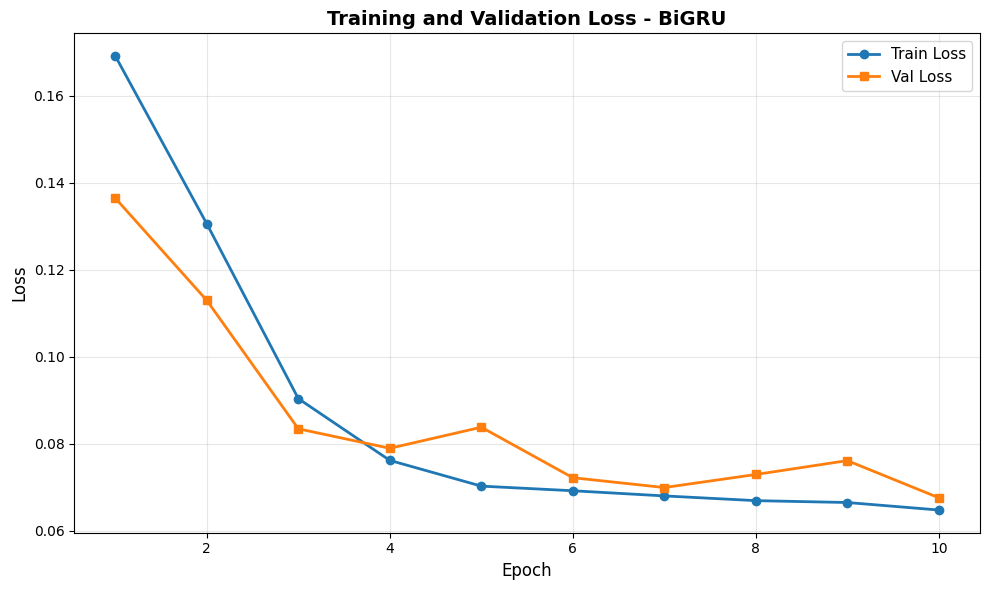

In [ ]:
# Train RNN with BiGRU + Attention
# from signal_dataloader import create_signal_dataloader
# from training import train_model

import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm

# config = Config()

# Create save directory
os.makedirs(config.SAVE_DIR, exist_ok=True)

print("="*45)
print("RNN MODEL TRAINING TEST")
print("="*45)
print(f"Device: {config.DEVICE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Learning rate: {config.LEARNING_RATE}")

config = Config()
# Load data
print("\nLoading data...")
print("Creating signals dataloaders...")
# Create dataloaders
train_dataloader = create_signal_dataloader(
    image_path=config.TRAIN_SIGNAL_PATH,
    labels_path=config.TRAIN_LABEL_PATH,
    saved_batch_size=config.SAVED_BATCH_SIZE,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS
)
data_iter = iter(train_dataloader)
batch0 = next(data_iter)
# batch0 is a tuple (signals, labels) so use the first element's first dim
batch_size_report = batch0[0].size(0) if hasattr(batch0[0], 'size') else len(batch0[0])
print(f"✓ Train batches: {len(train_dataloader)}")
print(f"✓ Batch size: {batch_size_report}")
val_dataloader = create_signal_dataloader(
    image_path=config.VAL_SIGNAL_PATH,
    labels_path=config.VAL_LABEL_PATH,
    saved_batch_size=config.SAVED_BATCH_SIZE,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS
)
data_iter = iter(val_dataloader)
batch0 = next(data_iter)
batch_size_report = batch0[0].size(0) if hasattr(batch0[0], 'size') else len(batch0[0])
print(f"✓ Val batches: {len(val_dataloader)}")
print(f"✓ Batch size: {batch_size_report}")
del data_iter
del batch0

# Create models to test
models_to_train = {
    'BiGRU': create_bigru(
        hidden_size=config.HIDDEN_SIZE,
        num_layers=config.NUM_LAYERS,
        dropout=config.DROPOUT
    ),
    'BiLSTM': create_bilstm(
        hidden_size=config.HIDDEN_SIZE,
        num_layers=config.NUM_LAYERS,
        dropout=config.DROPOUT
    ),
    'BiGRU_AddAttention': create_bigru_attention(
        hidden_size=config.HIDDEN_SIZE,
        num_layers=config.NUM_LAYERS,
        dropout=config.DROPOUT,
        attention_type='additive'
    ),
    'BiGRU_SelfAttention': create_bigru_attention(
        hidden_size=config.HIDDEN_SIZE,
        num_layers=config.NUM_LAYERS,
        dropout=config.DROPOUT,
        attention_type='self'
    )
    # 'CRNN_1D': CRNN_1D(3, 5, 'gru', 128, 2, True, 0.4)
}
# Train each model
histories = []
model_names = []

# Loss function (Binary Cross Entropy for multi-label)
criterion = nn.BCEWithLogitsLoss()
metrics = ECGMetrics(config.CLASS_NAMES)
viz = TrainingVisualizer(config.CLASS_NAMES)

for name, model in models_to_train.items():
    print(f"Training Model: {name}")
    # Optimizer
    model = model.to(config.DEVICE)
    optimizer = optim.Adam(model.parameters(),
                           lr=config.LEARNING_RATE,
                           weight_decay=config.WEIGHT_DECAY)
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3,
        min_lr=1e-6
    )

    history, class_wise_metrics = train_model(
        model,
        name,
        train_dataloader,
        val_dataloader,
        criterion,
        optimizer,
        scheduler,
        metrics,
        config,
    )
    histories.append(history)
    model_names.append(name)

    # Plot history
    viz.plot_loss_curves(history, f'{config.TRAIN_HISTORY_SAVE_PATH}/{name}_loss_currves.png', name)
    viz.plot_macro_metrics(history, f'{config.TRAIN_HISTORY_SAVE_PATH}/{name}_macro_metrics.png', name)
    viz.plot_training_summary(history, f'{config.TRAIN_HISTORY_SAVE_PATH}/{name}_training_history.png', name)

    # Per-class metrics (requires class_wise_metrics)
    viz.plot_per_class_metric(class_wise_metrics, save_path = f'{config.TRAIN_HISTORY_SAVE_PATH}/{name}_per_class_metric.png', name=name)
    viz.plot_per_class_metric(class_wise_metrics, )  # All classes

# Save histories to disk for future analysis
print("\nSaving training histories...")
save_histories(histories, model_names)

# Plot results
plot_training_history(histories, model_names)

print("\n" + "="*45)
print("✓ ALL TRAINING COMPLETE")
print("="*45)


### Example 2: Train CNN2D AlexNet (Image-based)


In [ ]:
# Train AlexNet with CBAM attention
# from image_dataloader import create_image_dataloader

# Create dataloaders
train_loader = create_image_dataloader(
    config.TRAIN_IMAGE_PATH, config.TRAIN_LABEL_PATH, image_type='gaf',
    batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS
)

val_loader = create_image_dataloader(
    config.VAL_IMAGE_PATH, config.VAL_LABEL_PATH, image_type='gaf',
    batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)

# Create model
alexnet_model = create_alexnet_cbam(num_classes=config.NUM_CLASSES, dropout=config.DROPOUT)

# Train
alexnet_history = train_model(
    model=alexnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    model_name='AlexNet_CBAM'
)

print("\n✓ AlexNet training completed!")


### Example 3: Train ResNet


In [ ]:
# Train ResNet
# from image_dataloader import create_image_dataloader

# Create dataloaders (reuse from above or create new)
train_loader = create_image_dataloader(
    config.TRAIN_IMAGE_PATH, config.TRAIN_LABEL_PATH, image_type='gaf',
    batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS
)

val_loader = create_image_dataloader(
    config.VAL_IMAGE_PATH, config.VAL_LABEL_PATH, image_type='gaf',
    batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)

# Create model
resnet_model = ResNet(num_classes=config.NUM_CLASSES)

# Train
resnet_history = train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    model_name='ResNet'
)

print("\n✓ ResNet training completed!")


### Example 4: Train Joint Fusion Model


In [ ]:
# Train Fusion Model combining Signal + Image
# from fusion_dataloader import create_fusion_dataloader

# Create dataloaders
train_loader = create_fusion_dataloader(
    config.TRAIN_SIGNAL_PATH, config.TRAIN_IMAGE_PATH, config.TRAIN_LABEL_PATH,
    image_type='gaf', batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS
)

val_loader = create_fusion_dataloader(
    config.VAL_SIGNAL_PATH, config.VAL_IMAGE_PATH, config.VAL_LABEL_PATH,
    image_type='gaf', batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)

# Create signal branch
signal_branch = create_bigru_attention(
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT
)

# Create image branch
image_branch = create_alexnet(num_classes=config.NUM_CLASSES, dropout=config.DROPOUT)

# Create fusion model
fusion_model = JointFusion(
    signal_model=signal_branch,
    image_model=image_branch,
    num_classes=config.NUM_CLASSES,
    fusion_dim=128
)

# Train
fusion_history = train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    model_name='JointFusion'
)

print("\n✓ Fusion model training completed!")


## 21. Evaluation on Test Set


In [ ]:
# Load and evaluate any trained model
import torch
# from metrics import ECGMetrics

def load_and_evaluate(model, model_name, test_loader, config):
    """Load best checkpoint and evaluate"""
    device = config.DEVICE
    checkpoint_path = os.path.join(config.SAVE_DIR, f"{model_name}_best.pth")

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded checkpoint: {checkpoint_path}")
        print(f"  Best epoch: {checkpoint['epoch']+1}")
        print(f"  Validation loss: {checkpoint['val_loss']:.4f}")
    else:
        print(f"⚠ No checkpoint found, using current model weights")

    # Evaluate
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if isinstance(inputs, (list, tuple)):
                inputs = [inp.to(device) for inp in inputs]
            else:
                inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Handle attention models

            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Calculate metrics
    metrics_calc = ECGMetrics()
    metrics = metrics_calc.calculate_metrics(y_true, y_pred, y_prob)

    # Print report
    print("\n" + "="*80)
    print(f"EVALUATION RESULTS - {model_name}")
    print("="*80)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    if 'auc_roc_macro' in metrics:
        print(f"AUC-ROC (Macro): {metrics['auc_roc_macro']:.4f}")
    print("="*80)

    # Plot confusion matrix
    metrics_calc.plot_confusion_matrices(
        [(metrics['confusion_matrix'], model_name)],
        save_path=f'results/{model_name}_confusion_matrix.png'
    )

    # Plot ROC curves
    metrics_calc.plot_roc_curves(
        y_true, y_prob,
        title=f'{model_name} - ROC Curves',
        save_path=f'results/{model_name}_roc_curves.png'
    )

    return metrics

print("✓ Evaluation function ready")


In [ ]:
# Example: Evaluate RNN model
from signal_dataloader import create_signal_dataloader

test_loader = create_signal_dataloader(
    config.TEST_SIGNAL_PATH, config.TEST_LABEL_PATH,
    batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)

# Uncomment after training
# rnn_results = load_and_evaluate(rnn_model, 'RNNModel', test_loader, config)


## 22. Download Results


In [ ]:
# Zip and download all results
import shutil

# Create archives
shutil.make_archive('ecg_results', 'zip', 'results')
shutil.make_archive('ecg_checkpoints', 'zip', config.SAVE_DIR)

print("✓ Archives created:")
print("  - ecg_results.zip")
print("  - ecg_checkpoints.zip")

# Download if on Colab
if IN_COLAB:
    from google.colab import files
    files.download('ecg_results.zip')
    files.download('ecg_checkpoints.zip')
    print("✓ Downloads started")


## 23. Tips & Troubleshooting

### Common Issues:

**Out of Memory:**
- Reduce `BATCH_SIZE` (try 16 or 8)
- Reduce `NUM_WORKERS` to 0
- Use `torch.cuda.empty_cache()`

**Data Not Found:**
- Verify you uploaded .npy files to correct directories
- Check file shapes match expected dimensions
- Run `check_data()` function

**Training Not Converging:**
- Try different learning rates
- Check data normalization
- Increase epochs
- Reduce dropout

**Colab Disconnection:**
- Save checkpoints to Google Drive
- Consider Colab Pro for longer runtime
- Use `%%capture` to suppress long outputs

### Performance Tips:
- Enable GPU: Runtime → Change runtime type → GPU (T4 or better)
- Monitor GPU: Run `!nvidia-smi` in a cell
- Use mixed precision training for speed (add to training.py)
- Reduce image size if memory constrained
